<center> 
    <a href="https://github.com/nebuly-ai/nebullvm#how-nebullvm-works" target="_blank" style="text-decoration: none;"> How Nebullvm Works </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#tutorials" target="_blank" style="text-decoration: none;"> Tutorials </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#benchmarks" target="_blank" style="text-decoration: none;"> Benchmarks </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#installation" target="_blank" style="text-decoration: none;"> Installation </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#get-started" target="_blank" style="text-decoration: none;"> Get Started </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#optimization-examples" target="_blank" style="text-decoration: none;"> Optimization Examples </a>
</center>
<center> 
    <a href="https://discord.com/invite/RbeQMu886J" target="_blank" style="text-decoration: none;"> Discord </a> |
    <a href="https://nebuly.ai/" target="_blank" style="text-decoration: none;"> Website </a> |
    <a href="https://www.linkedin.com/company/72460022/" target="_blank" style="text-decoration: none;"> LinkedIn </a> |
    <a href="https://twitter.com/nebuly_ai" target="_blank" style="text-decoration: none;"> Twitter </a>
</center>

# Accelerate fast.ai Resnet34 with nebullvm

Hi and welcome 👋

In this notebook we will discover how in just a few steps you can speed up the response time of deep learning model inference using the open-source library nebullvm.

With nebullvm's latest API, you can speed up models up to 10 times without any loss of accuracy (option A), or accelerate them up to 20-30 times by setting a self-defined amount of accuracy/precision that you are willing to trade off to get even lower response time (option B). To accelerate your model, nebullvm takes advantage of various optimization techniques such as deep learning compilers (in both option A and option B), quantization, half accuracy, and so on (option B).

Let's jump to the code.

# Fine-tune a fast.ai model

For the tutorial, we will use a fast.ai notebook for beginners in which we will classify whether the input image contains a cat (`True` label) or a dog (`False` label). Note that this notebook is not intended to be an in-depth guide to fast.ai libraries but, rather, shows how to use nebullvm to speed up fast.ai algorithms at inference time.

First let's download a sample of images of dogs and cats.

In [1]:
from fastai.vision.all import *

/Users/emilec/miniforge3/envs/nebullvm_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


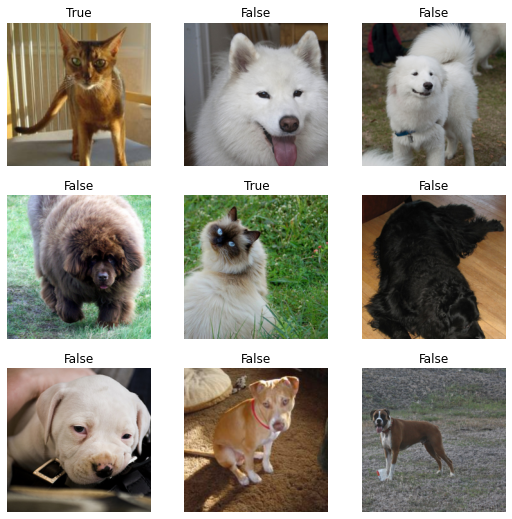

In [2]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224), num_workers=0)
dls.show_batch()

Let's now fine-tune the fast.ai model.

In [3]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/Users/emilec/miniforge3/envs/nebullvm_env/lib/python3.8/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,0.150739,0.027126,0.006766,10:52


epoch,train_loss,valid_loss,error_rate,time
0,0.060032,0.009236,0.002706,16:04


In [4]:
valid_loss, error = learn.validate()

Now that we have fine-tuned the model, let's calculate the time required to run a prediction as an average over 100 tests.

In [5]:
import time

In [6]:
%%capture
times = []
for _ in range(100):
    st = time.time()
    preds = learn.predict(files[0])
    times.append((time.time()-st)*1000)
fastai_vanilla_time = sum(times)/len(times)

In [7]:
print(f"Average prediction time: {fastai_vanilla_time} ms,\nPrediction: {preds}")

Average prediction time: 103.1537413597107 ms,
Prediction: ('True', TensorBase(1), TensorBase([1.4507e-07, 1.0000e+00]))


In [8]:
#learn.save(".")

# Speed up fast.ai inference with nebullvm

In [9]:
from nebullvm import optimize_torch_model

/Users/emilec/Documents/nebuly_workspace/nebullvm/nebullvm/inference_learners/openvino.py:37: UserWarning: No Openvino library detected. The Openvino Inference learner should not be used.
  warnings.warn(
/Users/emilec/Documents/nebuly_workspace/nebullvm/nebullvm/inference_learners/tvm.py:45: UserWarning: Not found any valid tvm installation. TVM will not be available in the following steps.
  warnings.warn(


Nebullvm was built to be very easy to use. To optimize a model, you only need to specify the model, the batch size and input size for each input tensor, and a directory in which to save the optimized model. In the example, we chose the same directory in which this notebook runs.

With the latest API, there are two ways to use nebullvm:

- Option A: Accelerate the model up to ~10 times without losing in performances (accuracy/precision/etc.)
- Option B: Accelerate the model up to ~30 times with a pre-defined maximum loss in performances
    - B1: Performance is measured on your dataset with a performance metric that you specify.
    - B2: Performance is measured on your dataset using precision as a metric.
    - B3: Performance is measured using precision as a metric.

To learn more about how to use nebullvm, check out the <a href="https://github.com/nebuly-ai/nebullvm#get-started" target="_blank" style="text-decoration: none;"> readme on GitHub </a>.

In this example, we provide the code to run option B.1 on the fast.ai model and you find commented out code for the other options as well. 

We set:

- Accuracy as performance metric
- Performance loss threshold to around 0.001

Now we prepare the dataset so that it can be processed by nebullvm.

In [10]:
xs, ys = [], []
for i, (x, y) in enumerate(dls.train):
    if i >=10:
        break
    xs.append(x)
    ys.append(y)
xs = torch.cat(xs, dim=0)
ys = torch.cat(ys, dim=0)

In [11]:
dl_nebullvm = [((x.unsqueeze(dim=0),), y.unsqueeze(0)) for x, y in zip(xs, ys)]

In [12]:
original_model = learn.model

In [13]:
## Option A: 2-10x acceleration, NO performance loss

# optimized_model = optimize_torch_model(
#     model=original_model,
#     batch_size=1,
#     input_sizes=[(3, 224, 224)],
#     save_dir=".",
#     #use_torch_api=True
# )

In [14]:
## Option B.1: 2-30x acceleration, maximum performance loss below your 
## perf_loss_ths, where performance is measured on your dataset dl_nebullvm
## with your performance metric perf_metric.

optimized_model = optimize_torch_model(
    model=original_model,
    batch_size=1,
    save_dir=".",
    dataloader=dl_nebullvm,
    #use_torch_api=True,
    perf_loss_ths=0.005,
    perf_metric="accuracy",
)

In [15]:
## Option B.2: 2-30x acceleration, maximum performance loss below your 
## perf_loss_ths, where performance is measured on your dataset dl_nebullvm
## using precision as a metric. Read more on GitHub on how to set perf_loss_ths.

# optimized_model = optimize_torch_model(
#     model=original_model,
#     batch_size=1,
#     save_dir=".",
#     dataloader=dl_nebullvm,
#     #use_torch_api=True,
#     perf_loss_ths=3,
# )

In [16]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, core):
        super().__init__()
        self.core = optimized_model
    
    def forward(self, *args, **kwargs):
        res = self.core(*args, **kwargs)
        if isinstance(res, tuple) and len(res) == 1:
            res = res[0]
        return res
    
    def parameters(self, *args, **kwargs):
        yield torch.zeros(100)

In [17]:
core_model = ModelWrapper(optimized_model)

In [18]:
learn.model = core_model

In [19]:
learn.dls.valid.bs = 1

In [20]:
optz_valid_loss, optz_error = learn.validate(dl=learn.dls.valid)

Let's calculate the time required to run a prediction as an average over 100 tests.

In [21]:
%%capture
times = []
for _ in range(100):
    st = time.time()
    preds = learn.predict(files[0])
    times.append((time.time()-st)*1000)
optimized_time = sum(times) / len(times)

In [22]:
print(f"Average prediction time: {optimized_time} ms,\nAverage prediction: {preds}")

Average prediction time: 28.48015785217285 ms,
Average prediction: ('True', tensor(1), tensor([6.0472e-06, 9.9999e-01]))


In [23]:
print(f"Full precision error: {error}\nError after optimization: {optz_error}")

Full precision error: 0.002706359839066863
Error after optimization: 0.002706359839066863


## Print the results

In [24]:
# Enter here your username
your_username = "username"

In [25]:
## Uncomment the following line for installing gputil if you are running on an NVIDIA GPU.
#!pip install gputil

In [26]:
import cpuinfo
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
cpu_info = cpuinfo.get_cpu_info()['brand_raw']
gpu_info = "no"
if torch.cuda.is_available():
    import GPUtil
    gpus = GPUtil.getGPUs()
    gpu_info = list(gpus)[0].name

In [27]:
message = f"""
Hello, I'm {your_username}!
I tested nebullvm with the following setup.

Hardware: {cpu_info} CPU and {gpu_info} GPU.
Model: {learn.arch.__name__} - fast.ai for image classification
Vanilla performance: {round(fastai_vanilla_time, 2)}ms
Optimized performance: {round(optimized_time, 2)}ms
Speedup: {round(fastai_vanilla_time/optimized_time, 1)}x
With error increase of {round((optz_error-error)/error*100, 1)}%
"""
print(message)


Hello, I'm username!
I tested nebullvm with the following setup.

Hardware: Apple M1 CPU and no GPU.
Model: resnet34 - fast.ai for image classification
Vanilla performance: 103.15ms
Optimized performance: 28.48ms
Speedup: 3.6x
With error increase of 0.0%



Great! Was it easy? How are the results? Do you have any comments?
Share your optimization results and thoughts with <a href="https://discord.gg/RbeQMu886J" target="_blank"> our community on Discord</a>, where we chat about nebullvm and AI acceleration.

Note that the acceleration of nebullvm depends very much on the hardware configuration and your AI model. Given the same input model, nebullvm can accelerate it by 10 times on some machines and perform poorly on others.

If you want to learn more about how nebullvm works, look at other tutorials and performance benchmarks, check out the links below or write to us on Discord.

<center> 
    <a href="https://github.com/nebuly-ai/nebullvm#how-nebullvm-works" target="_blank" style="text-decoration: none;"> How Nebullvm Works </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#tutorials" target="_blank" style="text-decoration: none;"> Tutorials </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#benchmarks" target="_blank" style="text-decoration: none;"> Benchmarks </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#installation" target="_blank" style="text-decoration: none;"> Installation </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#get-started" target="_blank" style="text-decoration: none;"> Get Started </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#optimization-examples" target="_blank" style="text-decoration: none;"> Optimization Examples </a>
</center>
<center> 
    <a href="https://discord.com/invite/RbeQMu886J" target="_blank" style="text-decoration: none;"> Discord </a> |
    <a href="https://nebuly.ai/" target="_blank" style="text-decoration: none;"> Website </a> |
    <a href="https://www.linkedin.com/company/72460022/" target="_blank" style="text-decoration: none;"> LinkedIn </a> |
    <a href="https://twitter.com/nebuly_ai" target="_blank" style="text-decoration: none;"> Twitter </a>
</center>